In [1]:
import numpy as np
import pandas as pd
import json
import rasterio
import matplotlib.pyplot as plt
import cv2

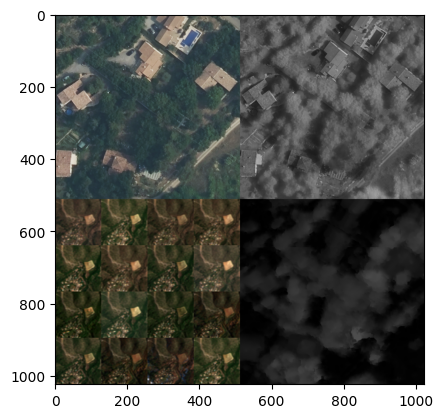

In [8]:
df = pd.read_csv("train.csv")

path = df.iloc[0]["img_path"]

######### sentinel image #############
parts = path.split('/')

idx_centroid = json.load(open("flair-2_centroids_sp_to_patch.json"))

sen_path = "flair_sen_train/"
sen_img_path = sen_path + parts[-4] +'/'+ parts[-3] + "/sen/SEN2_sp_" + parts[-4]+'-'+parts[-3]+"_data.npy"

x = np.load(sen_img_path)
indices = np.random.randint(x.shape[0], size=16) # take random 16
x = x[indices]

patch_size = 64 # 40-112
a, b = idx_centroid[parts[-1]]
x = x[:,:3,::]
x = x[:,:,a-int(patch_size/2):a+int(patch_size/2),b-int(patch_size/2):b+int(patch_size/2)]

img_rows = []
for min_id in range(0, 16, 4):
    img_row = np.hstack([i for i in x[min_id:min_id+4]])
    img_rows.append(img_row.transpose(2, 1, 0))
img = np.vstack(img_rows)

img = img[:,:,::-1] #RGB
img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_CUBIC)
min, max = img.min(), img.max()
sen_img = (img - min) / (max - min)
sen_img = (sen_img*255).astype(int)
#####################################

with rasterio.open(path) as image:
    image = np.array(image.read())#[:3]

img, img2, img3 = image[:3], image[3:4], image[4:5]
img = img.transpose(1, 2, 0)

new_img = np.vstack((img, sen_img))

image2 = np.concatenate((img2, img2, img2), axis=0).transpose(1,2,0)
image3 = np.concatenate((img3, img3, img3), axis=0).transpose(1,2,0)

img23 = np.vstack((image2, image3))

img4 = np.hstack((new_img, img23))

plt.imshow(img4);